In [ ]:
!pip install sklearn-genetic

Подгрузим библиотке которые будем использовать

In [2]:
import pandas as pd
from genetic_selection import GeneticSelectionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel('new_features.xlsx')#Подгружаем датасет

In [4]:
X = data.drop(['TPSA'], axis=1)
y = data['TPSA']
#Выбираем таргетный парметр

In [5]:
estimator = RandomForestRegressor()
#В качестве оценочного алгоритма выбрем алгоритм случайного леса
#Первым попробуем генетический алгоритм
model = GeneticSelectionCV(
    estimator, cv=5, verbose=0,
    scoring="r2", max_features=5,
    n_population=5, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=20,
    caching=True, n_jobs=-1)

model = model.fit(X, y)

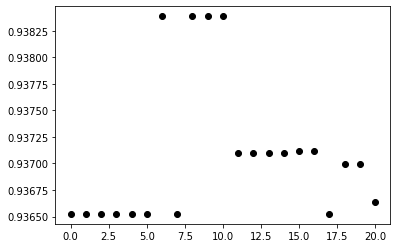

In [9]:
plt.plot(model.generation_scores_, 'o', color='black')

In [14]:
#Поссмотрим какие колонки были выбраны как наиболее важные 
#x006 - HBondDonorCount
#x008 - RotatableBondCount
#x010 - IsotopeAtomCount
#x015 - CovalentUnitCount
#x017 - XStericQuadrupole3D
print('Features:', X.columns[model.support_])

Features: Index(['x017', 'x011*log(x015)', 'x006*sqrt(x010)', 'x008*sqrt(x017)',
       'x006**2*log(x015)'],
      dtype='object')


Попробуем метод SequentialFeatureSelector


In [10]:
sfs1 = sfs(estimator,
           n_features_to_select=5,
           scoring='r2',
           cv=5)

sfs1 = sfs1.fit(X, y)

In [ ]:
estimator_sfs = RandomForestRegressor()
estimator_sfs.fit(X.loc[:, sfs1.support_], y)

In [15]:
#Поссмотрим какие колонки были выбраны как наиболее важные 
#x003 - MonoisotopicMass
#x005 - Charge
#x006 - HBondDonorCount
#x009 - HeavyAtomCount
#x018 - YStericQuadrupole3D

print('Features:', X.columns[sfs1.support_])

Features: Index(['x005', 'x018**5', 'x006*x009', 'x006**3*x018**3',
       'x003**2*sqrt(x006)'],
      dtype='object')


In [12]:
import numpy as np 
r2 = estimator_sfs.score(X.loc[:, sfs1.support_], y)
print('R-squared:', np.round(r2, decimals=4))

R-squared: 0.9965


Метод показал высокое значение коэффициента детерминации близкий к 1.

Посмотрим что сможет показать нам Recursive feature elimination.

In [13]:
estimator_rfe = RandomForestRegressor()
selector = RFE(estimator_rfe, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

In [16]:
selector.get_feature_names_out()
#Поссмотрим какие колонки были выбраны как наиболее важные 

#x005 - Charge
#x006 - HBondDonorCount
#x007 - HBondAcceptorCount
#x009 - HeavyAtomCount
#x018 - YStericQuadrupole3D

array(['x005', 'x006', 'x006*x009', 'x006**3*x018**3', 'x005*x007'],
      dtype=object)

In [17]:
print('R-squared:', np.round(selector.score(X, y), decimals=4))

R-squared: 0.9953


Метод показал себя хорошо коэффциент детерминации всего на одну тысячную ниже чем у предыдущего алгоритма. Так же были выделены почти те же столбцы из чего можно сделать вывод, что стобцы 5, 6, 9 в нашем датасете имют наибольшую значимость.

Потестируем менее эффективные но от это не менее полезные алгоритмы.
Приведенный ниже алгоритм можно использовать для удаления столбцов у которых значения threshold ниже заданного порога. Полезен для отчистки датасета от колонок содержащих много нулевых значений.

In [26]:
selector_t = VarianceThreshold(threshold=0.9)
selector_t.fit_transform(X)

array([[ 0.00000000e+00,  9.00000000e-01,  7.40731649e+01, ...,
         1.41421356e+00,  1.00000000e+00,  3.60555128e+00],
       [ 1.00000000e+00,  2.10000000e+00,  7.59441424e+01, ...,
         0.00000000e+00,  0.00000000e+00,  6.00000000e+00],
       [ 2.00000000e+00, -4.60000000e+00,  4.27029416e+02, ...,
         6.92820323e+00,  0.00000000e+00,  7.14422844e+01],
       ...,
       [ 2.34700000e+03,  2.92000000e+00,  2.90050578e+02, ...,
         3.63318042e+00,  6.32455532e-01,  2.98496231e+01],
       [ 2.34800000e+03,  9.00000000e-01,  5.99667558e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.34900000e+03, -5.00000000e-01,  3.20262147e+01, ...,
         0.00000000e+00,  0.00000000e+00,  1.41421356e+00]])

In [27]:
selector_t.get_feature_names_out()

array(['Unnamed: 0', 'x000', 'x001', 'x002', 'x003', 'x005', 'x006',
       'x007', 'x008', 'x009', 'x010', 'x012', 'x013', 'x014', 'x016',
       'x017', 'x018', 'x018**5', 'x006*x009', 'x005/x015',
       'x011*x012**2', 'sqrt(x006)/x015', 'x006**3*x018**3',
       'x006*sqrt(x013)', 'x006*sqrt(x010)', 'x003**2*sqrt(x006)',
       'x003**2*sqrt(x010)', 'sqrt(x009)*sqrt(x018)', 'x000*x016',
       'sqrt(x007)', 'x007*x018**3', 'x002*sqrt(x005)', 'x006*sqrt(x011)',
       'x003**3*x014**3', 'x000**2*x004**2', 'x012**2*x018**3',
       'x009**3*x010**2', 'x012**2*exp(x013)', 'sqrt(x010)*x018**2',
       'x005**2*sqrt(x012)', 'sqrt(x002)*sqrt(x018)', 'x005*x014',
       'x005*x007', 'x004*x018**2', 'x006*x014**2', 'x000*x010**2',
       'x007**2*x018**3', 'sqrt(x016)/x015', 'x006*sqrt(x012)',
       'x008*sqrt(x017)', 'sqrt(x016)*x018', 'x013**3*x016**3',
       'sqrt(x008)/x015', 'x009**2*Abs(x000)', 'x008**2*log(x015)',
       'x006**2*log(x015)', 'x006**2*sqrt(x017)', 'x002**3*sqrt(x0

In [5]:
from sklearn.feature_selection import SelectFromModel
import numpy as np
from sklearn.linear_model import RidgeCV

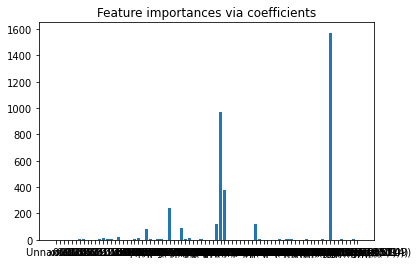

In [7]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(X.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [12]:
threshold = np.sort(importance)[-6] + 0.01

sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)


In [13]:
sfm.get_feature_names_out()

array(['sqrt(x009)/x002', 'sqrt(x003)/x002', 'x003**3*x014**3',
       'sqrt(x005)/x002', 'x002**3*sqrt(x012)'], dtype=object)

SelectFromModel предлагает использовать фичи схожие с теми что предлагает SequentialFeatureSelector(хотя мы и использовали другой алгоритм для оценки), но в более измененном с математической точки зрения варианте. 
Из всех выше перечисленных алгоритмов на наших данных лучше вссего себя показал SequentialFeatureSelector.